# Recommending Indian Restaurant Startup Venue in Toronto Neighborhood

## Web Scraping Toronto Postal Codes

In [140]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json # library to handle JSON files
import requests # library to handle requests
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-3.3.0               |           py36_0         747 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

In [2]:
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
page = requests.get(URL)

In [4]:
soup = BeautifulSoup(page.text, 'html.parser')

In [5]:
columns = ['PostalCode','Borough','Neighborhood']

In [6]:
postaltable = soup.find_all('table')[0]

### Converting Postal Codes html table info to Pandas Dataframe

In [7]:
df = pd.read_html(str(postaltable))

In [10]:
postalcodes = df[0]

In [11]:
postalcodes.columns = columns

In [12]:
postalcodes.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Narrow down the dataframe to ignore/exclude Not Assigned Boroughs

In [13]:
postalcodes = postalcodes[postalcodes['Borough'] != 'Not assigned']

### Grouping the Neighborhoods w.r.t each Boroughs

In [14]:
toronto_pcodes = postalcodes.groupby(['PostalCode','Borough'])['Neighborhood'].agg(', '.join).to_frame()

In [15]:
toronto_pcodes = toronto_pcodes.reset_index()

In [16]:
toronto_pcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
PostalCode      103 non-null object
Borough         103 non-null object
Neighborhood    103 non-null object
dtypes: object(3)
memory usage: 2.5+ KB


In [17]:
toronto_pcodes.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [18]:
toronto_pcodes.shape

(103, 3)

#### Overall 103 postal codes are identified and integrated in the dataframe

# Append Coordinates with help of GeoSpatial data

In [19]:
!wget -q -O 'geospatial_coordinates.csv' http://cocl.us/Geospatial_data
print('data downloaded')

data downloaded


In [20]:
geo_coord = pd.read_csv('geospatial_coordinates.csv')
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging Coordinates with Toronto Postal Codes dataframe

In [21]:
toronto_postal_coord = pd.merge(left=toronto_pcodes, right=geo_coord, left_on = 'PostalCode', right_on = 'Postal Code', how='inner')

In [22]:
toronto_postal_coord.drop(columns=['Postal Code'], inplace=True)

In [23]:
toronto_postal_coord.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [29]:
# Toronto Coordinates
Latitude = 43.6532
Longitude = -79.3832

### Toronto Neighborhood map view

In [147]:
map_toronto = folium.Map(location=[Latitude, Longitude], zoom_start = 12)

for lat, lng, lbl in zip(toronto_postal_coord['Latitude'], toronto_postal_coord['Longitude'], toronto_postal_coord['Neighborhood']):
    label = folium.Popup(lbl, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        fill = True,
        color = 'blue',
        fill_color = 'yellow',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(map_toronto)
map_toronto

## Explore Indian Neighborhoods in Toronto

### Web Scraping Demographics of Toronto

In [72]:
TorontoEthnicURL = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto'

In [73]:
EthnicPage = requests.get(TorontoEthnicURL)

In [74]:
soup1 = BeautifulSoup(EthnicPage.text, 'html.parser')

### Identifying the neighborhoods with highest percentage of specific Ethnic origin

In [75]:
for tag in soup1.findAll('p'):
    if tag.get_text().startswith('The neighbourhoods with the highest percentage of'):
        section = tag
        ethnicpercentage = section.find_next('ul').find_all('li')
ethnicpercentage

[<li>Milliken: 97% (top ethnic origin: Chinese)</li>,
 <li>Steeles: 91% (top ethnic origin: Chinese)</li>,
 <li>Agincourt North: 91% (top ethnic origin: Chinese)</li>,
 <li>Malvern: 90% (top ethnic origin: East Indian)</li>,
 <li>West Humber-Clairville: 87% (top ethnic origin: East Indian)</li>,
 <li>Mount Olive-Silverstone-Jamestown: 87% (top ethnic origin: East Indian)</li>,
 <li>Agincourt South-Malvern West: 86% (top ethnic origin: Chinese)</li>,
 <li>Black Creek: 81% (top ethnic origin: Vietnamese)</li>,
 <li>Rouge: 81% (top ethnic origin: East Indian)</li>,
 <li>Flemingdon Park: 79% (top ethnic origin: East Indian)</li>,
 <li>Thorncliffe Park: 79% (top ethnic origin: Pakistani)</li>]

### Transforming the web scraped data to Pandas Dataframe

In [76]:
cols = ['Neighborhood','Top_Ethnic_Origin']
top_neighborhood_origin = pd.DataFrame(columns=cols)
#top_neighborhood_origin
#top_origin = {}
for i in range(0, len(ethnicpercentage)):
    val = ethnicpercentage[i]
    val = val.string.replace('top ethnic origin','')
    val = val.replace('(','')
    val = val.replace(')','')
    val = val.replace(':','')
    #top_origin[]
    top_neighborhood_origin = top_neighborhood_origin.append( { 'Neighborhood':' '.join(val.split('%')[0].split('-')[-1].split(' ')[:-1]), 'Top_Ethnic_Origin': val.split(' ')[-1]}, ignore_index= True)


    

In [77]:
top_neighborhood_origin

,Neighborhood,Top_Ethnic_Origin
0,Milliken,Chinese
1,Steeles,Chinese
2,Agincourt North,Chinese
3,Malvern,Indian
4,Clairville,Indian
5,Jamestown,Indian
6,Malvern West,Chinese
7,Black Creek,Vietnamese
8,Rouge,Indian
9,Flemingdon Park,Indian


### Narrowing down to Indian Ethnic Origin Neighborhoods

In [78]:
top_neighborhood_origin = top_neighborhood_origin[top_neighborhood_origin['Top_Ethnic_Origin'] == 'Indian']

In [79]:
top_neighborhood_origin

,Neighborhood,Top_Ethnic_Origin
3,Malvern,Indian
4,Clairville,Indian
5,Jamestown,Indian
8,Rouge,Indian
9,Flemingdon Park,Indian


##### Translating specific Neighborhoods to actual or alias neighborhoods to match the postal codes data

In [110]:
top_neighborhood_origin.loc[top_neighborhood_origin['Neighborhood'] == 'Clairville', 'Neighborhood'] = 'Northwest'

Series([], Name: Neighborhood, dtype: object)

In [111]:
top_neighborhood_origin

,Neighborhood,Top_Ethnic_Origin
3,Malvern,Indian
4,Northwest,Indian
5,Jamestown,Indian
8,Rouge,Indian
9,Flemingdon Park,Indian


### Merging with Postal codes and Borough info

In [112]:
postalcodes.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [113]:
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [114]:
Indian_neighborhood = pd.merge(left=top_neighborhood_origin, right=postalcodes, left_on='Neighborhood', right_on='Neighborhood', how='inner')

In [115]:
Indian_neighborhood

,Neighborhood,Top_Ethnic_Origin,PostalCode,Borough
0,Malvern,Indian,M1B,Scarborough
1,Northwest,Indian,M9W,Etobicoke
2,Jamestown,Indian,M9V,Etobicoke
3,Rouge,Indian,M1B,Scarborough
4,Flemingdon Park,Indian,M3C,North York


### Merging with Coordinates using Geospatial data

In [116]:
Indian_neighborhood = pd.merge(left=Indian_neighborhood, right=geo_coord, left_on='PostalCode', right_on='Postal Code', how='left')

In [117]:
Indian_neighborhood.drop(columns=['Postal Code'], axis=1, inplace=True)

In [118]:
Indian_neighborhood

,Neighborhood,Top_Ethnic_Origin,PostalCode,Borough,Latitude,Longitude
0,Malvern,Indian,M1B,Scarborough,43.806686,-79.194353
1,Northwest,Indian,M9W,Etobicoke,43.706748,-79.594054
2,Jamestown,Indian,M9V,Etobicoke,43.739416,-79.588437
3,Rouge,Indian,M1B,Scarborough,43.806686,-79.194353
4,Flemingdon Park,Indian,M3C,North York,43.725900,-79.340923


### Toronto Indian Neighborhood map view

In [153]:
map_indian_toronto = folium.Map(location=[Latitude, Longitude], zoom_start = 11)

for lat, lng, lbl in zip(Indian_neighborhood['Latitude'], Indian_neighborhood['Longitude'], Indian_neighborhood['Neighborhood']):
    label = folium.Popup(lbl, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 7,
        popup = label,
        fill = True,
        color = 'Blue',
        fill_color = 'Yellow',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(map_indian_toronto)
map_indian_toronto

### Let's create a function to consume the Foursquare API which returns the Venues details based on the Neighborhood Coordinates requested

### Define Foursquare Credentials and Version

In [30]:
# The code was removed by Watson Studio for sharing.

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT = 10
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Fetch the Venues of corresponding Indian Neighborhoods

In [119]:
Indian_neighborhood_venues = getNearbyVenues(names=Indian_neighborhood['Neighborhood'],
                                   latitudes=Indian_neighborhood['Latitude'],
                                   longitudes=Indian_neighborhood['Longitude']
                                  )

Malvern
Northwest
Jamestown
Rouge
Flemingdon Park


In [121]:
print('Number of unique Categories of Venues present in Indian Neighborhood : {}'.format(len(Indian_neighborhood_venues['Venue Category'].unique())))

Number of unique Categories of Venues present in Indian Neighborhood : 18


In [122]:
Indian_neighborhood_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Malvern,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Northwest,43.706748,-79.594054,Economy Rent A Car,43.708471,-79.589943,Rental Car Location
2,Northwest,43.706748,-79.594054,Saand Rexdale,43.705072,-79.598725,Drugstore
3,Jamestown,43.739416,-79.588437,Subway,43.742421,-79.589471,Sandwich Place
4,Jamestown,43.739416,-79.588437,Shoppers Drug Mart,43.741685,-79.584487,Pharmacy
5,Jamestown,43.739416,-79.588437,Popeyes Louisiana Kitchen,43.741202,-79.584545,Fried Chicken Joint
6,Jamestown,43.739416,-79.588437,The Beer Store,43.741694,-79.584373,Beer Store
7,Jamestown,43.739416,-79.588437,Sheriff's No Frills,43.741696,-79.584379,Grocery Store
8,Jamestown,43.739416,-79.588437,Pizza Pizza,43.741569,-79.584489,Pizza Place
9,Jamestown,43.739416,-79.588437,McDonald's,43.741757,-79.584230,Fast Food Restaurant


### Grouping Stats of Venues per Indian Neighborhood

In [123]:
Indian_neighborhood_stat = Indian_neighborhood_venues.groupby(['Neighborhood'])['Venue'].count().to_frame()

In [124]:
Indian_neighborhood_stat = Indian_neighborhood_stat.reset_index()

In [125]:
Indian_neighborhood_stat

,Neighborhood,Venue
0,Flemingdon Park,10
1,Jamestown,7
2,Malvern,1
3,Northwest,2
4,Rouge,1


### Visual Exploration of Group stats

#### Venue Stats at Indian Origin Neighborhoods

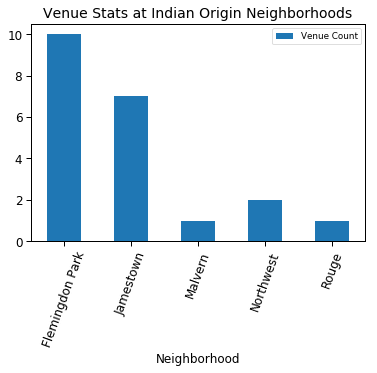

In [210]:
import matplotlib.pyplot as plt

Indian_neighborhood_stat.plot(kind='bar', x='Neighborhood',y='Venue', label='Venue Count', fontsize=12)
plt.title('Venue Stats at Indian Origin Neighborhoods', fontsize=14)
plt.xticks(rotation=70)
plt.xlabel('Neighborhood', fontsize=12)
plt.show()

#### Restaurant Venue Stats at Indian Origin Neighborhoods

In [155]:
Indian_neighborhood_restaurant_venues = Indian_neighborhood_venues.loc[Indian_neighborhood_venues['Venue Category'].str.contains('Restaurant')]

In [156]:
Indian_neighborhood_restaurant_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Malvern,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
9,Jamestown,43.739416,-79.588437,McDonald's,43.741757,-79.584230,Fast Food Restaurant
10,Rouge,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
11,Flemingdon Park,43.725900,-79.340923,Sorento Restaurant,43.726575,-79.341989,Italian Restaurant
15,Flemingdon Park,43.725900,-79.340923,Swiss Chalet Rotisserie & Grill,43.726737,-79.341403,Restaurant
20,Flemingdon Park,43.725900,-79.340923,Memories of Japan,43.727347,-79.341364,Japanese Restaurant


In [157]:
Indian_neighborhood_restaurants_stat = Indian_neighborhood_restaurant_venues.groupby(['Neighborhood'])['Venue'].count().to_frame()
Indian_neighborhood_restaurants_stat = Indian_neighborhood_restaurants_stat.reset_index()

#### Restaurant venues per Indian Neighborhood 

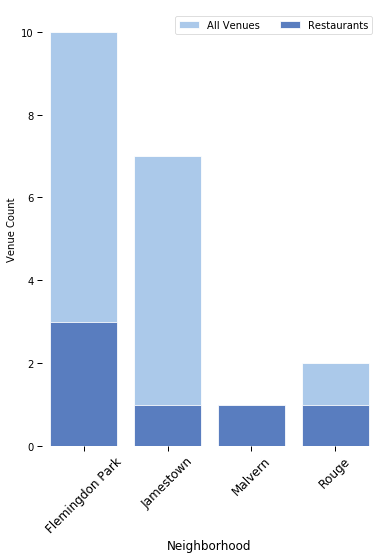

In [199]:
import seaborn as sns

f, ax = plt.subplots(figsize = (6,8))
sns.set_color_codes('pastel')
sns.barplot(x = 'Neighborhood', y = 'Venue', data = Indian_neighborhood_stat,
            label = 'All Venues', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'Neighborhood', y = 'Venue', data = Indian_neighborhood_restaurants_stat,
            label = 'Restaurants', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'upper right', fontsize=10)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('Neighborhood',fontsize=12)
plt.ylabel('Venue Count', fontsize=10)
sns.despine(left = True, bottom = True)
plt.show()